In [1]:
try:
    import torch
except:
    !pip install torch
    import torch

try:
    import captum
except:
    !pip install captum
    import captum

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score
from captum.attr import IntegratedGradients

In [2]:
df = pd.read_csv('../LLCP2023_clean.csv', keep_default_na=False, dtype='category')

### Training hyperparameters

In [3]:
learning_rate = 1e-3
batch_size = 64
epochs = 25

Setting device for training

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Encoding and splitting data into training and testing sets

In [5]:
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [6]:
X = df.drop(columns=['_MENT14D'])
y = df['_MENT14D']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
y_test.value_counts().sort_index()

_MENT14D
0    7472
1    3548
2    5070
Name: count, dtype: int64

In [8]:
y_train.value_counts().sort_index()

_MENT14D
0    29884
1    14192
2    20281
Name: count, dtype: int64

#### Dataset class for BRFSS data

In [9]:
class BRFSSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = BRFSSDataset(X_train, y_train)
test_dataset = BRFSSDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Definition of Neural Network model

### Model structure

In [10]:
class MentalHealthClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


input_size = X_train.shape[1]  # Number of features
num_classes = len(y.unique())  # Number of target classes
model = MentalHealthClassifier(input_size, num_classes).to(device)
print(model)

MentalHealthClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
    (7): Softmax(dim=1)
  )
)


### Training and testing loops

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Training of Neural Network model

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.100055  [   64/64357]
loss: 0.893600  [ 6464/64357]
loss: 0.904380  [12864/64357]
loss: 0.837950  [19264/64357]
loss: 0.888578  [25664/64357]
loss: 0.834571  [32064/64357]
loss: 0.911067  [38464/64357]
loss: 0.838047  [44864/64357]
loss: 0.860882  [51264/64357]
loss: 0.846337  [57664/64357]
loss: 0.821186  [64064/64357]
Test Error: 
 Accuracy: 68.3%, Avg loss: 0.856400 

Epoch 2
-------------------------------
loss: 0.839359  [   64/64357]
loss: 0.783633  [ 6464/64357]
loss: 0.860384  [12864/64357]
loss: 0.915853  [19264/64357]
loss: 0.885392  [25664/64357]
loss: 0.868120  [32064/64357]
loss: 0.830121  [38464/64357]
loss: 0.895880  [44864/64357]
loss: 0.780477  [51264/64357]
loss: 0.950129  [57664/64357]
loss: 0.873137  [64064/64357]
Test Error: 
 Accuracy: 68.7%, Avg loss: 0.853399 

Epoch 3
-------------------------------
loss: 0.882922  [   64/64357]
loss: 0.862399  [ 6464/64357]
loss: 0.915274  [12864/64357]
loss: 0.800510  [19264/643

## Evaluation

In [13]:
y_pred_prob = []
y_pred = []
y_true = []
model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        prob = model(X).to('cpu')
        y_pred_prob += prob.tolist()
        pred = prob.argmax(axis=1)
        y_pred += pred.tolist()
        y_true += y.to('cpu').tolist()

In [14]:
accuracy_score(y_true, y_pred)

0.7055313859540087

In [15]:
f1_score(y_true, y_pred, average='weighted')

0.7023440046597151

In [16]:
classification_report(y_true, y_pred, output_dict=True)

{'0': {'precision': 0.718065693430657,
  'recall': 0.7372858672376874,
  'f1-score': 0.7275488642366614,
  'support': 7472.0},
 '1': {'precision': 0.669374779229954,
  'recall': 0.5341037204058624,
  'f1-score': 0.5941370120708575,
  'support': 3548.0},
 '2': {'precision': 0.7066404152496868,
  'recall': 0.778698224852071,
  'f1-score': 0.7409214600731914,
  'support': 5070.0},
 'accuracy': 0.7055313859540087,
 'macro avg': {'precision': 0.6980269626367659,
  'recall': 0.683362604165207,
  'f1-score': 0.6875357787935701,
  'support': 16090.0},
 'weighted avg': {'precision': 0.7037287435262684,
  'recall': 0.7055313859540087,
  'f1-score': 0.7023440046597151,
  'support': 16090.0}}

In [17]:
roc_auc_score(y_true, y_pred_prob, multi_class='ovo')

0.8529498039730058

## Save trained model weights

In [18]:
torch.save(model.state_dict(), '../model-weights/nn_model.pt')

### Load model

In [19]:
model.load_state_dict(torch.load('../model-weights/nn_model.pt', weights_only=True))
model.eval()

MentalHealthClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
    (7): Softmax(dim=1)
  )
)

## Model understanding

### Using Captum package to calculate feature attributions

In [20]:
ig = IntegratedGradients(model.to('cpu'))
attribution_tensors = []
    
for target_class_index in range(3):
    for X, y in train_loader:
        attribution_tensors += ig.attribute(X.to('cpu'), target=target_class_index)

In [21]:
# Calculate mean attribution per column
attributions = torch.vstack(attribution_tensors).mean(dim=0)

# Rescale values between 0 and 1 for better visualization
attributions -= attributions.min()
attributions /= (attributions.max() - attributions.min())

columns_attribution = pd.DataFrame({
    "column": [X_train.columns[i] for i in attributions.sort(descending=True)[1].tolist()],
    "attribution": attributions.sort(descending=True)[0].tolist()
})
columns_attribution

,column,attribution
0,SDLONELY,1.000000
1,ADDEPEV3,0.605694
2,_SMOKER3,0.594207
3,_RFCHOL3,0.588797
4,_DRNKWK21,0.581030
5,_IMPRACE,0.580703
6,CHCSCNC,0.577773
7,_ASTHMS1,0.570693
8,CVDSTRK3,0.567871
9,POORHLTH,0.566505


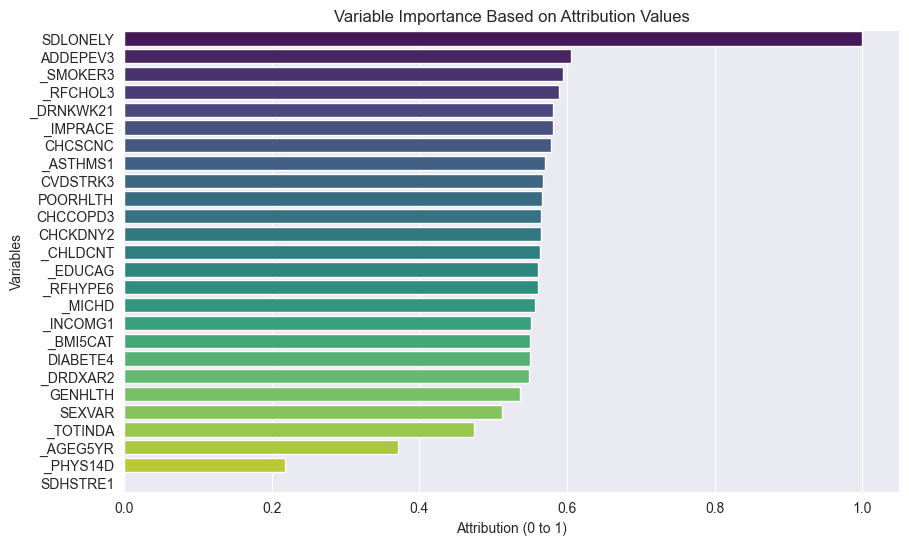

In [22]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x='attribution',
    y='column',
    data=columns_attribution,
    palette="viridis",
    orient="h"
)

plt.title("Variable Importance Based on Attribution Values")
plt.xlabel("Attribution (0 to 1)")
plt.ylabel("Variables")

plt.show()